<a href="https://colab.research.google.com/github/SeanLing94/Conventional-CNN-model/blob/main/Assessment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the Dataset

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T074312Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D558caf5184a0e4c2dc8f87b50aa48d3dc7415e782930899098b8c7ffa6e946302f303626379d37bf8a54f6e484c2ebb6d85101f286517a28835e7a946e17a368b49f1538978474e5d5954b5828963b7b8451a5fda3c4017641dcd916c32f44c11fd14ec79ab30b41ef0885b0715f097a83215500fbae444db818cebbe34a31bec0e51c8a18ea7f56e3c2fb23dca537c34762d68e97ed8d489869eed96a49b8f9c2388379204acdc80639eb22a5ea8ba4e2682f3cf6641f0417e4afa798107bf42b356988067f93d0ab32eede74dffd752a3e3c4b8cf10525e2af5ca0e0a8336714129f6618e3077b0051bd86bc42f1382ebf726d8ae64a16592874634c9fc58a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


Load & Exploring the Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.applications import VGG16, ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Define directories
base_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_pneumonia_dir = base_dir + 'train/PNEUMONIA/'
train_normal_dir = base_dir + 'train/NORMAL/'
test_pneumonia_dir = base_dir + 'test/PNEUMONIA/'
test_normal_dir = base_dir + 'test/NORMAL/'
val_normal_dir = base_dir + 'val/NORMAL/'
val_pneumonia_dir = base_dir + 'val/PNEUMONIA/'

# Load image paths
train_pn = [train_pneumonia_dir + "{}".format(i) for i in os.listdir(train_pneumonia_dir)]
train_normal = [train_normal_dir + "{}".format(i) for i in os.listdir(train_normal_dir)]
test_pn = [test_pneumonia_dir + "{}".format(i) for i in os.listdir(test_pneumonia_dir)]
test_normal = [test_normal_dir + "{}".format(i) for i in os.listdir(test_normal_dir)]
val_pn = [val_pneumonia_dir + "{}".format(i) for i in os.listdir(val_pneumonia_dir)]
val_normal = [val_normal_dir + "{}".format(i) for i in os.listdir(val_normal_dir)]

# Combine image paths
train_imgs = train_pn + train_normal
test_imgs = test_pn + test_normal
val_imgs = val_pn + val_normal

# Shuffle the datasets
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

# Print dataset statistics
print("Total Train Images:", len(train_imgs))
print("Total Test Images:", len(test_imgs))
print("Total Validation Images:", len(val_imgs))

Total Train Images: 5216
Total Test Images: 624
Total Validation Images: 16


Preprocessing the image

(5216, 224, 224, 3) (5216,)
(624, 224, 224, 3) (624,)
(16, 224, 224, 3) (16,)


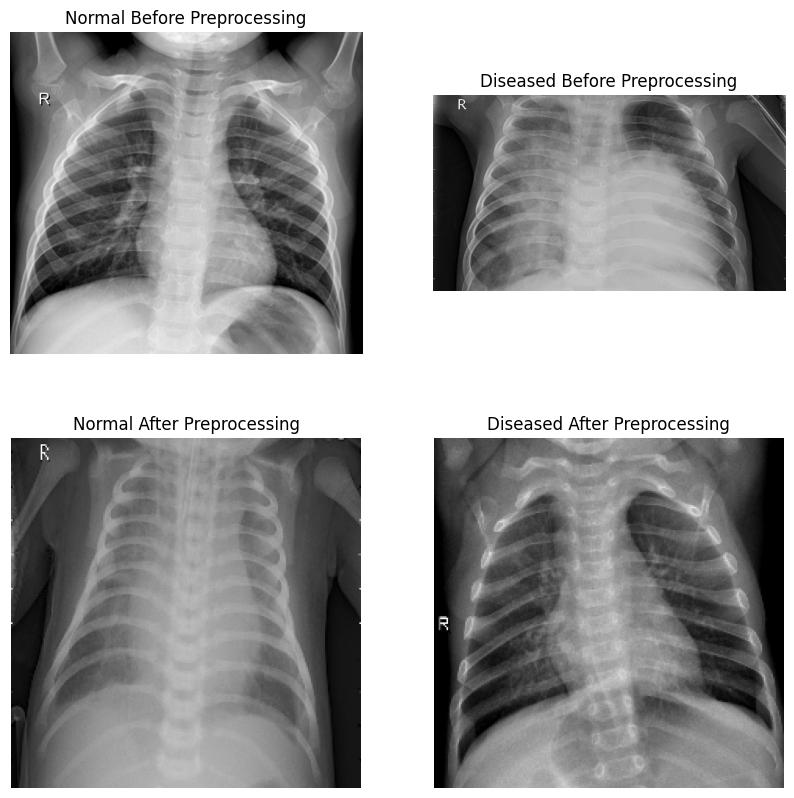

In [ ]:
import matplotlib.pyplot as plt

img_size = 224

def preprocess_image(image_list):
    X = []
    y = []
    for image in image_list:
        try:
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
            img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            if 'NORMAL' in image:
                y.append(0)
            else:
                y.append(1)
        except:
            continue
    return np.array(X), np.array(y)

X_train, y_train = preprocess_image(train_imgs)
X_test, y_test = preprocess_image(test_imgs)
X_val, y_val = preprocess_image(val_imgs)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

# Display two samples each from normal and diseased classes before preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.imread(train_normal[0], cv2.IMREAD_COLOR))
plt.title("Normal Before Preprocessing")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(cv2.imread(train_pn[0], cv2.IMREAD_COLOR))
plt.title("Diseased Before Preprocessing")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(X_train[0])
plt.title("Normal After Preprocessing")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(X_train[-1])
plt.title("Diseased After Preprocessing")
plt.axis("off")

plt.show()

Class Weight

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


Define the CNN Models

In [ ]:
#Conventional CNN Model
def build_cnn_model():
    model = tf.keras.models.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Pre-trained ResNet50 Model
def build_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Pre-trained DenseNet201 Model
def build_densenet_model():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Visualizations of the layers for each models

74836368/74836368 [==============================] - 5s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.47441 to fit



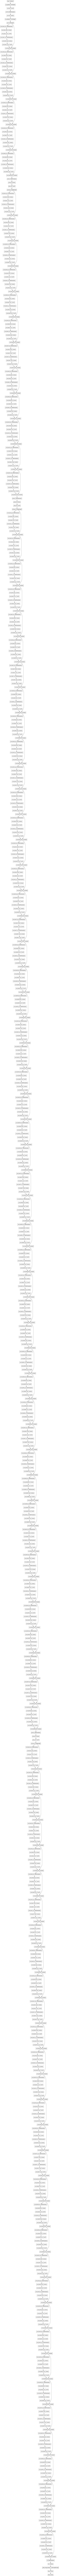

In [ ]:
#Conventional CNN Model
from keras.utils import plot_model
model = build_cnn_model()
plot_model(model, to_file='cnn_model.png')

#Pre-trained ResNet50 Model
from keras.utils import plot_model
model = build_resnet_model()
plot_model(model, to_file='resnet_model.png')

#Pre-trained DenseNet201 Model
from keras.utils import plot_model
model = build_densenet_model()
plot_model(model, to_file='densenet_model.png')

74836368/74836368 [==============================] - 1s 0us/step


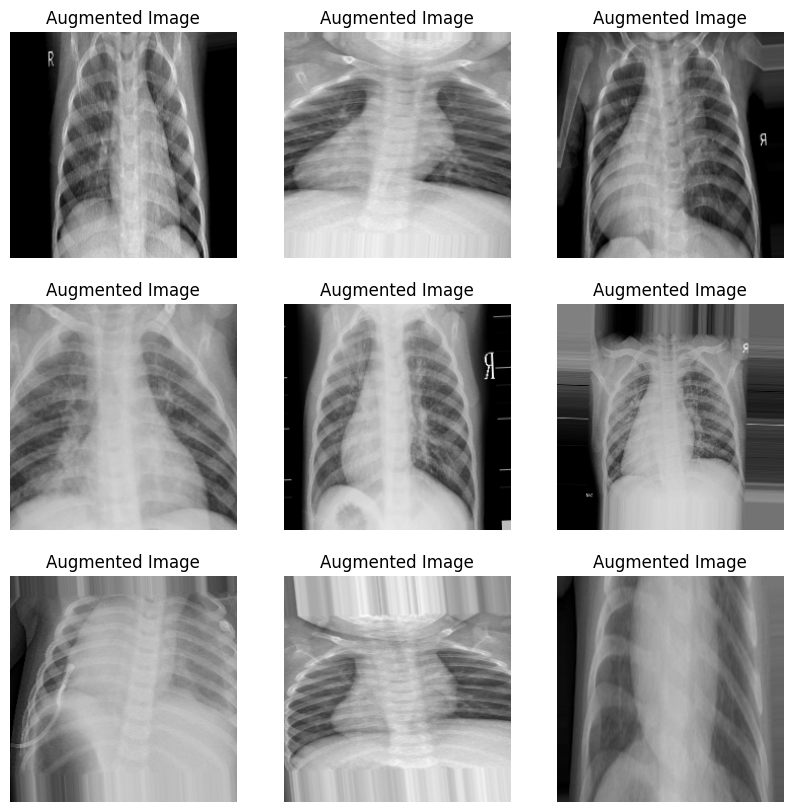

In [ ]:
cnn_model = build_cnn_model()
resnet_model = build_resnet_model()
densenet_model = build_densenet_model()

train_datagen = ImageDataGenerator(rotation_range=7, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.2, zoom_range=0.45, horizontal_flip=True)
val_datagen = ImageDataGenerator(zoom_range=0.45)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.title("Augmented Image")
    plt.axis("off")
plt.show()

Train the Models

In [ ]:
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data=val_generator)
resnet_history = resnet_model.fit(train_generator, epochs=20, validation_data=val_generator)
densenet_history = densenet_model.fit(train_generator, epochs=20, validation_data=val_generator)

74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/20
163/163 [==============================] - 58s 316ms/step - loss: 0.5236 - accuracy: 0.7820 - val_loss: 2.1230 - val_accuracy: 0.5625
Epoch 2/20
163/163 [==============================] - 52s 318ms/step - loss: 0.3382 - accuracy: 0.8495 - val_loss: 1.8923 - val_accuracy: 0.5625
Epoch 3/20
163/163 [==============================] - 52s 316ms/step - loss: 0.2967 - accuracy: 0.8740 - val_loss: 1.8386 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 52s 316ms/step - loss: 0.2736 - accuracy: 0.8819 - val_loss: 1.0815 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 51s 315ms/step - loss: 0.2569 - accuracy: 0.8915 - val_loss: 1.6817 - val_accuracy: 0.6250
Epoch 6/20
163/163 [==============================] - 52s 317ms/step - loss: 0.2297 - accuracy: 0.9055 - val_loss: 0.8737 - val_accuracy: 0.6875
Epoch 7/20
163/163 [==============================] - 51s 314ms/s

**Fine-Tuning of Models**

Including the ReduceLROnPlateau callback in Keras adjusts the learning rate based on the performance of the model on the validation set

Epoch 1/20
163/163 [==============================] - 53s 315ms/step - loss: 0.4283 - accuracy: 0.8062 - val_loss: 1.6461 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - 52s 317ms/step - loss: 0.2957 - accuracy: 0.8704 - val_loss: 0.9866 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - 52s 317ms/step - loss: 0.2591 - accuracy: 0.8930 - val_loss: 1.0695 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - 51s 314ms/step - loss: 0.2377 - accuracy: 0.8993 - val_loss: 0.9772 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/20
163/163 [==============================] - 51s 314ms/step - loss: 0.2246 - accuracy: 0.9026 - val_loss: 1.6657 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 6/20
163/163 [==============================] - 51s 315ms/step - loss: 0.2098 - accuracy: 0.9110 - val_loss: 1.1408 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 7/20
163/163 [========

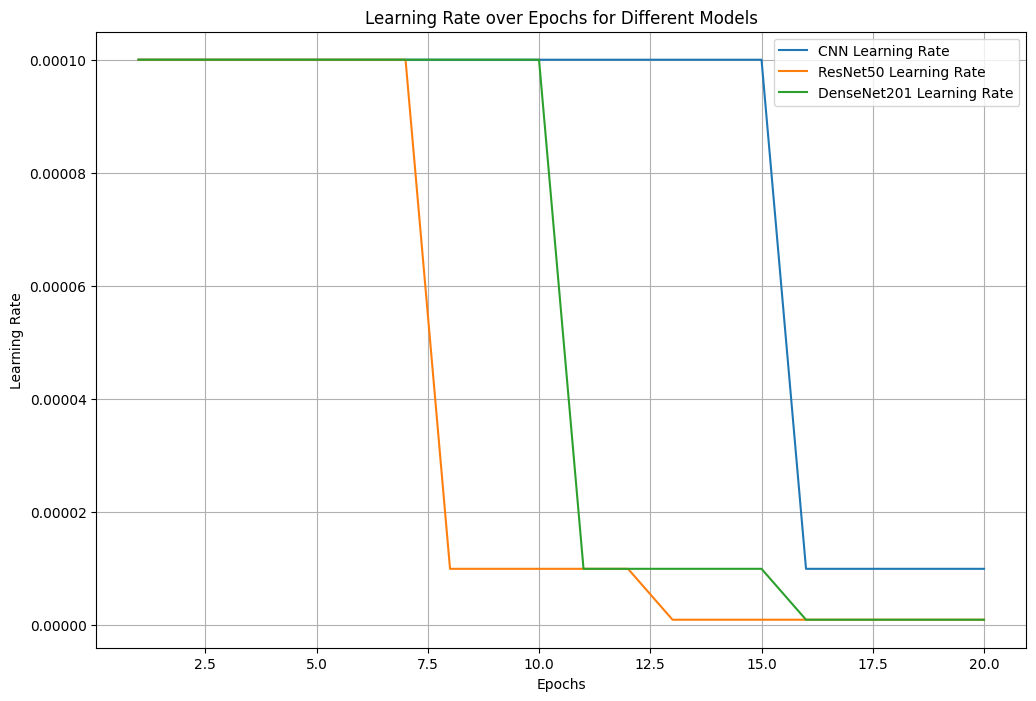

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

# Custom callback to track learning rate
class LearningRateTracker(Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        else:
            lr = lr.numpy()
        self.lrs.append(lr)
        print(f"Epoch {epoch + 1}: Learning rate is {lr}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

# Models building
# Fine-Tune the Conventional CNN Model
cnn_fine_tuned_model = build_cnn_model()
cnn_fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_lr_tracker = LearningRateTracker()
cnn_fine_tuned_history = cnn_fine_tuned_model.fit(train_generator, epochs=20, batch_size=32, validation_data=val_generator, callbacks=[reduce_lr, cnn_lr_tracker])

# Fine-Tune the Pre-trained ResNet50 Model
resnet_fine_tuned_model = build_resnet_model()
resnet_fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_lr_tracker = LearningRateTracker()
resnet_fine_tuned_history = resnet_fine_tuned_model.fit(train_generator, epochs=20, batch_size=32, validation_data=val_generator, callbacks=[reduce_lr, resnet_lr_tracker])

# Fine-Tune the Pre-trained DenseNet201 Model
densenet_fine_tuned_model = build_densenet_model()
densenet_fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
densenet_lr_tracker = LearningRateTracker()
densenet_fine_tuned_history = densenet_fine_tuned_model.fit(train_generator, epochs=20, batch_size=32, validation_data=val_generator, callbacks=[reduce_lr, densenet_lr_tracker])

# Plotting learning rate for all models
plt.figure(figsize=(12, 8))
epochs = range(1, 21)  # 20 epochs

plt.plot(epochs, cnn_lr_tracker.lrs, label='CNN Learning Rate')
plt.plot(epochs, resnet_lr_tracker.lrs, label='ResNet50 Learning Rate')
plt.plot(epochs, densenet_lr_tracker.lrs, label='DenseNet201 Learning Rate')

plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()

**Plot the Results**

Accuracy

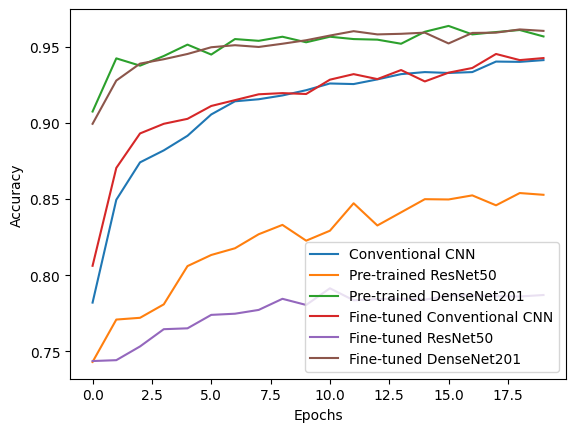

In [ ]:
plt.plot(cnn_history.history['accuracy'], label='Conventional CNN')
plt.plot(resnet_history.history['accuracy'], label='Pre-trained ResNet50')
plt.plot(densenet_history.history['accuracy'], label='Pre-trained DenseNet201')
plt.plot(cnn_fine_tuned_history.history['accuracy'], label='Fine-tuned Conventional CNN')
plt.plot(resnet_fine_tuned_history.history['accuracy'], label='Fine-tuned ResNet50')
plt.plot(densenet_fine_tuned_history.history['accuracy'], label='Fine-tuned DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Plot the Results**

-Accuracy & Loss

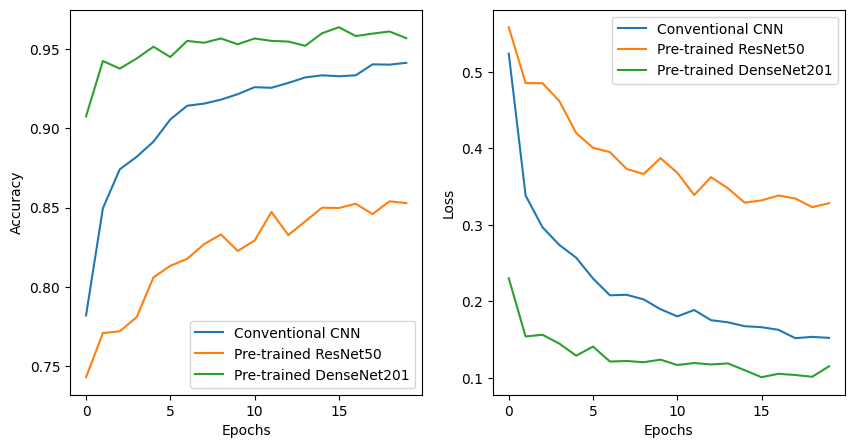

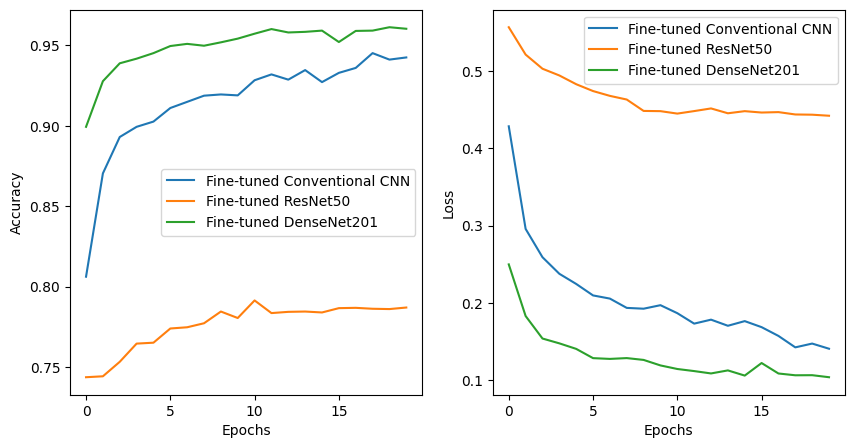

In [ ]:
# Plot the Accuracy and Loss for the Models
plt.figure(figsize=(10, 5))

# Before Fine-Tuning
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Conventional CNN')
plt.plot(resnet_history.history['accuracy'], label='Pre-trained ResNet50')
plt.plot(densenet_history.history['accuracy'], label='Pre-trained DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Conventional CNN')
plt.plot(resnet_history.history['loss'], label='Pre-trained ResNet50')
plt.plot(densenet_history.history['loss'], label='Pre-trained DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# After Fine-Tuning
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_fine_tuned_history.history['accuracy'], label='Fine-tuned Conventional CNN')
plt.plot(resnet_fine_tuned_history.history['accuracy'], label='Fine-tuned ResNet50')
plt.plot(densenet_fine_tuned_history.history['accuracy'], label='Fine-tuned DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_fine_tuned_history.history['loss'], label='Fine-tuned Conventional CNN')
plt.plot(resnet_fine_tuned_history.history['loss'], label='Fine-tuned ResNet50')
plt.plot(densenet_fine_tuned_history.history['loss'], label='Fine-tuned DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Select a Specific Input Instance for Prediction**

To make all models predict for a specific input instance and compare the predicted results

In [ ]:
# Select a Specific Input Instance
input_instance = X_test[0]

# Predictions
cnn_prediction = cnn_model.predict(input_instance.reshape(1, img_size, img_size, 3))
resnet_prediction = resnet_model.predict(input_instance.reshape(1, img_size, img_size, 3))
densenet_prediction = densenet_model.predict(input_instance.reshape(1, img_size, img_size, 3))

cnn_fine_tuned_prediction = cnn_fine_tuned_model.predict(input_instance.reshape(1, img_size, img_size, 3))
resnet_fine_tuned_prediction = resnet_fine_tuned_model.predict(input_instance.reshape(1, img_size, img_size, 3))
densenet_fine_tuned_prediction = densenet_fine_tuned_model.predict(input_instance.reshape(1, img_size, img_size, 3))

# Print the Predictions
print("Predictions:")
print(f"Conventional CNN: {cnn_prediction}")
print(f"Pre-trained ResNet50: {resnet_prediction}")
print(f"Pre-trained DenseNet201: {densenet_prediction}")
print(f"Fine-tuned Conventional CNN: {cnn_fine_tuned_prediction}")
print(f"Fine-tuned ResNet50: {resnet_fine_tuned_prediction}")
print(f"Fine-tuned DenseNet201: {densenet_fine_tuned_prediction}")

1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 1s 962ms/step


1/1 [==============================] - 3s 3s/step
Predictions:
Conventional CNN: [[0.7751887]]
Pre-trained ResNet50: [[0.85705566]]
Pre-trained DenseNet201: [[0.99997854]]
Fine-tuned Conventional CNN: [[0.81983924]]
Fine-tuned ResNet50: [[0.8180006]]
Fine-tuned DenseNet201: [[0.9987381]]


Evaluate the Models

In [ ]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = np.round(preds).astype(int)
    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    return acc, precision, recall, f1, cm

cnn_acc, cnn_precision, cnn_recall, cnn_f1, cnn_cm = evaluate_model(cnn_model, X_test, y_test)
resnet_acc, resnet_precision, resnet_recall, resnet_f1, resnet_cm = evaluate_model(resnet_model, X_test, y_test)
densenet_acc, densenet_precision, densenet_recall, densenet_f1, densenet_cm = evaluate_model(densenet_model, X_test, y_test)
cnn_fine_tuned_acc, cnn_fine_tuned_precision, cnn_fine_tuned_recall, cnn_fine_tuned_f1, cnn_fine_tuned_cm = evaluate_model(cnn_fine_tuned_model, X_test, y_test)
resnet_fine_tuned_acc, resnet_fine_tuned_precision, resnet_fine_tuned_recall, resnet_fine_tuned_f1, resnet_fine_tuned_cm = evaluate_model(resnet_fine_tuned_model, X_test, y_test)
densenet_fine_tuned_acc, densenet_fine_tuned_precision, densenet_fine_tuned_recall, densenet_fine_tuned_f1, densenet_fine_tuned_cm = evaluate_model(densenet_fine_tuned_model, X_test, y_test)

print(f"Conventional CNN - Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}, F1-score: {cnn_f1}")
print(f"Pre-trained ResNet50 - Accuracy: {resnet_acc}, Precision: {resnet_precision}, Recall: {resnet_recall}, F1-score: {resnet_f1}")
print(f"Pre-trained DenseNet201 - Accuracy: {densenet_acc}, Precision: {densenet_precision}, Recall: {densenet_recall}, F1-score: {densenet_f1}")
print(f"Fine-tuned Conventional CNN - Accuracy: {cnn_fine_tuned_acc}, Precision: {cnn_fine_tuned_precision}, Recall: {cnn_fine_tuned_recall}, F1-score: {cnn_fine_tuned_f1}")
print(f"Fine-tuned ResNet50 - Accuracy: {resnet_fine_tuned_acc}, Precision: {resnet_fine_tuned_precision}, Recall: {resnet_fine_tuned_recall}, F1-score: {resnet_fine_tuned_f1}")
print(f"Fine-tuned DenseNet201 - Accuracy: {densenet_fine_tuned_acc}, Precision: {densenet_fine_tuned_precision}, Recall: {densenet_fine_tuned_recall}, F1-score: {densenet_fine_tuned_f1}")

20/20 [==============================] - 2s 77ms/step
Conventional CNN - Accuracy: 0.8990384615384616, Precision: 0.8865248226950354, Recall: 0.9615384615384616, F1-score: 0.9225092250922509
Pre-trained ResNet50 - Accuracy: 0.8221153846153846, Precision: 0.8079470198675497, Recall: 0.9384615384615385, F1-score: 0.8683274021352314
Pre-trained DenseNet201 - Accuracy: 0.9038461538461539, Precision: 0.9104477611940298, Recall: 0.9384615384615385, F1-score: 0.9242424242424243
Fine-tuned Conventional CNN - Accuracy: 0.8814102564102564, Precision: 0.8708920187793427, Recall: 0.9512820512820512, F1-score: 0.9093137254901961
Fine-tuned ResNet50 - Accuracy: 0.7019230769230769, Precision: 0.6888888888888889, Recall: 0.9538461538461539, F1-score: 0.8000000000000002
Fine-tuned DenseNet201 - Accuracy: 0.9086538461538461, Precision: 0.8954869358669834, Recall: 0.9666666666666667, F1-score: 0.9297163995067818
